In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

from CreateDF import create_DF 
df = create_DF()

numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# Remove identifiers and previously calculated composite scores if they exist
features_to_exclude = [
    'District IRN', 'Overall Composite', 'Taxpayer Efficiency Score', 
    'Performance Opportunity Score', 'Final Value Score', 'Comprehensive Value Score',
    'Affordability & Value Score', 'Holistic Performance Score', 
    'Affordability & Complexity Index', 'Cost and Complexity Index'
]

# A list of features that are safe for modeling
modeling_features = [col for col in numerical_cols if col not in features_to_exclude]

# Create a new DataFrame for modeling
X = df[modeling_features].fillna(0) # Fill any remaining NaNs just in case

# Normalize the data: This is crucial for both PCA and K-Means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data prepared for modeling with shape:", X_scaled.shape)

C:\Users\kdelv\miniconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\kdelv\miniconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Data prepared for modeling with shape: (606, 58)


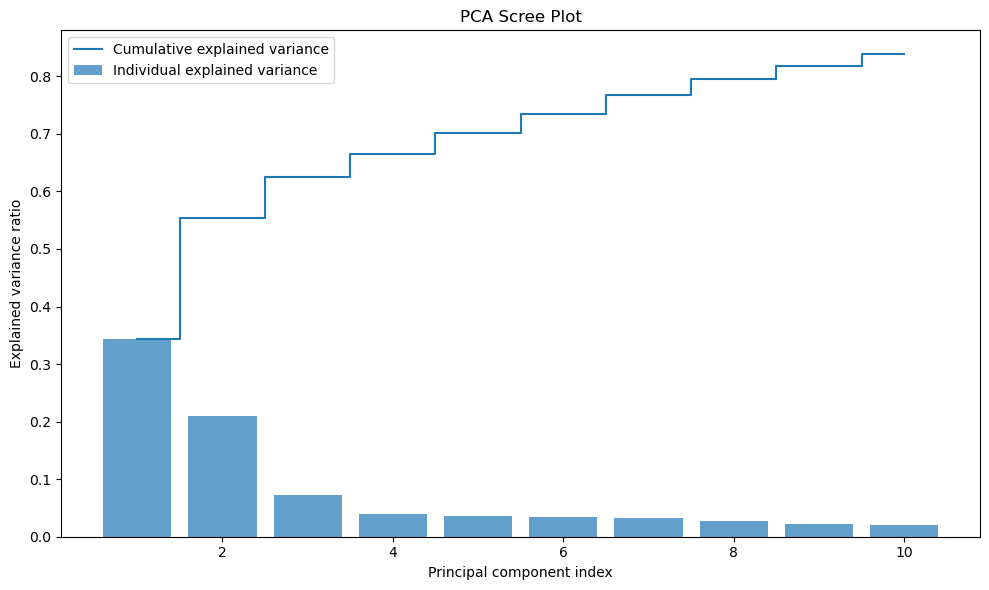

Top 10 features for PC1 (Academic Performance & Wealth):
Performance Index Score 2022-2023                 0.214948
Performance Index Score 2023-2024                 0.214508
Performance Index Percent 2023-2024               0.214481
Performance Index Score 2021-2022                 0.213176
Percent of Students Limited                       0.213098
Percent of Students Accomplished                  0.200091
Total Attendance Percent                          0.199116
Achievement Component Star Rating                 0.198951
Percent of Economically Disadvantaged Students    0.194186
Percent of Students Advanced                      0.191718
Name: PC1, dtype: float64

Top 10 features for PC2 (District Scale & Demographics):
Real Property Taxable Value (a)      0.259415
Total Students                       0.248928
NUMBER OF RETURNS                    0.234181
Students with Disabilities           0.226741
Multiracial                          0.218219
English Learner                      0.

In [3]:
# --- Step 2: Apply PCA ---
# We'll start by looking at 10 components to see how much variance they capture
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# --- Analyze the Explained Variance ---
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot the explained variance (Scree Plot)
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), explained_variance, alpha=0.7, align='center', label='Individual explained variance')
plt.step(range(1, 11), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('PCA Scree Plot')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# --- Interpret the Top 3 Principal Components ---
# Create a DataFrame to view the loadings (weights) of each original feature on the new components
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(10)], index=X.columns)

print("Top 10 features for PC1 (Academic Performance & Wealth):")
print(loadings['PC1'].abs().sort_values(ascending=False).head(10))
print("\nTop 10 features for PC2 (District Scale & Demographics):")
print(loadings['PC2'].abs().sort_values(ascending=False).head(10))
print("\nTop 10 features for PC3 (Taxation & Funding Structure):")
print(loadings['PC3'].abs().sort_values(ascending=False).head(10))

# Add the most important principal components to the original DataFrame
df['PC1_Academic_Wealth'] = X_pca[:, 0]
df['PC2_Scale_Demographics'] = X_pca[:, 1]
df['PC3_Tax_Funding'] = X_pca[:, 2]

C:\Users\kdelv\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\kdelv\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\kdelv\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\kdelv\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Wi

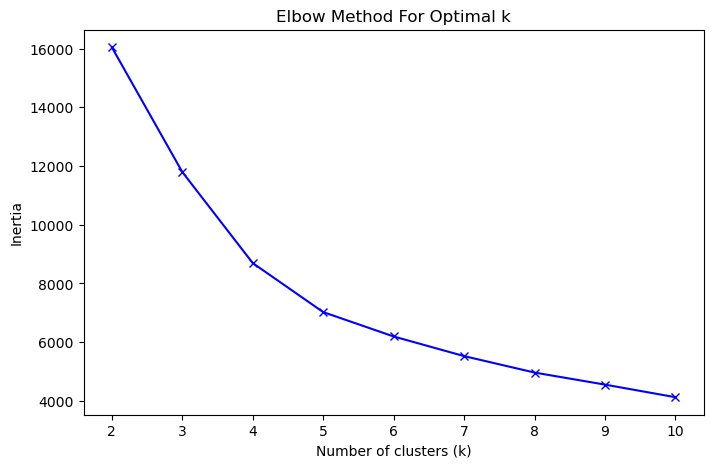

In [4]:
# --- Step 3.1: Find the Optimal Number of Clusters (Elbow Method) ---
# Use the first few principal components as input for clustering
X_for_clustering = X_pca[:, :4] # Use top 4 PCs

inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_for_clustering)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [5]:
# --- Step 3.2: Apply K-Means and Profile the Clusters ---
k = 4 # Based on the prompt and likely elbow point
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_for_clustering)

# --- Profile the created clusters ---
# Group by the new cluster label and find the mean of key metrics
cluster_profile = df.groupby('Cluster')[[
    'Performance Index Score 2023-2024',
    'MEDIAN OHIO ADJUSTED GROSS INCOME',
    'Total Local Tax Burden',
    'Total Students',
    'Percent of Economically Disadvantaged Students',
    'PC1_Academic_Wealth',
    'PC2_Scale_Demographics'
]].mean().sort_values(by='PC1_Academic_Wealth', ascending=False) # Sort by the main performance component

print("Cluster Profiles (Mean Values):")
display(cluster_profile)

# --- Map Meaningful Names to the Cluster Labels ---
# Create a mapping dictionary based on the sorted cluster profile
# The cluster with the highest PC1 is 'Tier 1', the next is 'Tier 2', and so on.
tier_map = {cluster_id: f'Tier {i+1}' for i, cluster_id in enumerate(cluster_profile.index)}

df['Cluster_Tier'] = df['Cluster'].map(tier_map)

# Display the final count and a sample of the data
print("\nNumber of districts in each tier:")
print(df['Cluster_Tier'].value_counts())

print("\nSample of DataFrame with new features:")
display(df[['District Name', 'County', 'PC1_Academic_Wealth', 'Cluster_Tier']].head())

Cluster Profiles (Mean Values):


C:\Users\kdelv\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


,Performance Index Score 2023-2024,MEDIAN OHIO ADJUSTED GROSS INCOME,Total Local Tax Burden,Total Students,Percent of Economically Disadvantaged Students,PC1_Academic_Wealth,PC2_Scale_Demographics
Cluster,,,,,,,
1,100.411765,58806.794118,3.335114,4151.745098,20.789630,4.916350,4.140620
3,87.318841,41345.213768,2.696945,1509.683575,49.786767,0.449421,-1.236466
0,68.514286,35136.464286,3.320408,3053.583333,86.006037,-6.969344,-0.261740
2,62.766667,36051.250000,3.980669,29471.500000,91.062813,-17.017213,18.589959



Number of districts in each tier:
Cluster_Tier
Tier 2    414
Tier 1    102
Tier 3     84
Tier 4      6
Name: count, dtype: int64

Sample of DataFrame with new features:


,District Name,County,PC1_Academic_Wealth,Cluster_Tier
District IRN,,,,
442,Manchester Local,Adams,-2.166032,Tier 2
43489,Akron City,Summit,-13.139583,Tier 4
43497,Alliance City,Stark,-6.001190,Tier 3
43505,Ashland City,Ashland,1.242657,Tier 2
43513,Ashtabula Area City,Ashtabula,-8.650993,Tier 3


In [6]:
# Save the final DataFrame with all the new analysis columns to a CSV file
df.to_csv('ohio_school_data_analyzed.csv', index=False)

print("DataFrame saved successfully to ohio_school_data_analyzed.csv")

DataFrame saved successfully to ohio_school_data_analyzed.csv
